In [1]:
#map TFs binding a promoter to their relevant coefficient of variation - see if they correspond to constitutive or variable
#Count TFs only once (only use unique TFs)
#this script will work for any promoter length

In [49]:
import pandas as pd
#import argparse
import os
import seaborn as sns
import matplotlib.pyplot as plt
#stats
from pingouin import kruskal
import scikit_posthocs as sp
from scipy import stats
from statannot import add_stat_annotation

In [2]:
# parser = argparse.ArgumentParser(description='map_TF2CV')
# parser.add_argument('file_names', type=str, help='Name of folder and filenames for the promoters extracted')
# parser.add_argument('Czechowski_gene_categories', type=str, help='Input location of Czechowski gene categories text file')
# parser.add_argument('Czechowski_all_cvs', type=str, help='Input location of Czechowski coefficient of variations for all genes in the microarray')
# parser.add_argument('mapped_motif_bed', type=str, help='Input location of promoters mapped motif bed')
# parser.add_argument('output_folder_name', type=str, help='Optional output folder name ending in a forward slash',default = '')

In [52]:
dependent_variable = 'TFBS_TF_class'
file_names = 'non-overlapping_includingbidirectional_all_genes_newannotation'
Czechowski_gene_categories = f'../../data/output/{file_names}/genes/promoters_5UTR_czechowski_constitutive_variable_random.txt'
Czechowski_rankedcv = f'../../data/genes/AtGE_dev_gcRMA__all_probes__CV.tsv'
mapped_motif_bed = f'../../data/output/{file_names}/FIMO/promoters_5UTR_400bp_motifs_mapped.bed'
output_folder_name = 'promoters_5UTR_400bp/'

In [4]:
#make directory for the plots to be exported to
dirName = f'../../data/output/{file_names}/{dependent_variable}'
try:
    # Create target Directory
    os.mkdir(dirName)
    print("Directory " , dirName ,  " created") 
except FileExistsError:
    print("Directory " , dirName ,  " already exists")

Directory  ../../data/output/non-overlapping_includingbidirectional_all_genes_newannotation/TFBS_TF_class  already exists


In [5]:
#make directory for the plots to be exported to
dirName = f'../../data/output/{file_names}/{dependent_variable}/{output_folder_name}'
try:
    # Create target Directory
    os.mkdir(dirName)
    print("Directory " , dirName ,  " created") 
except FileExistsError:
    print("Directory " , dirName ,  " already exists")

Directory  ../../data/output/non-overlapping_includingbidirectional_all_genes_newannotation/TFBS_TF_class/promoters_5UTR_400bp/  already exists


In [6]:
#make directory for the plots to be exported to
dirName = f'../../data/output/{file_names}/{dependent_variable}/{output_folder_name}plots'
try:
    # Create target Directory
    os.mkdir(dirName)
    print("Directory " , dirName ,  " created") 
except FileExistsError:
    print("Directory " , dirName ,  " already exists")

Directory  ../../data/output/non-overlapping_includingbidirectional_all_genes_newannotation/TFBS_TF_class/promoters_5UTR_400bp/plots  already exists


In [7]:
def map_cv(ranked_cvs_file,mapped_motifs_file):
    """function to map the CV value to the TFs which bind to each promoter"""
    #read in files
    cvs = pd.read_table(ranked_cvs_file, sep='\t', header=None)
    cols = ['rank','probe_id','TF_AGI','expression_mean','expression_SD','expression_CV','proportion_of_values_present_in_mas5','presence_in_araport11','constitutive_in_araport11']
    cvs.columns = cols
    #filter out any genes that aren't present in araport11
    cvs = cvs[cvs.presence_in_araport11==1]
    #read in mapped motifs
    mapped_motifs = pd.read_table(mapped_motifs_file, sep='\t', header=None)
    #if whole promoter, mapped motif will have 13 columns
    #if shortened promoter, mapped motif file will have 24 (as bp overlap is needed in TF_diversity_plots_shortenedprom.py to remove TFBSs where the middle isn't in the promoter)
    #if 24 columns, only select the subset of 13 columns
    #if 13 columns, keep them all
    #This is to make the dfs have identical column names
    if len(mapped_motifs.columns) == 24:
        cols = ['chr', 'start', 'stop', 'promoter_AGI','dot1','strand','source','type','dot2','attributes',
            'motif_chr','motif_start','motif_stop','name_rep', 'score', 'motif_strand',
            'promoter_AGI2', 'p-value', 'q-value', 'matched_sequence', 'TF_name', 'TF_family', 'TF_AGI','bp_overlap']
        mapped_motifs.columns = cols
        #filter columns
        mapped_motifs = mapped_motifs[['motif_chr','motif_start','motif_stop','name_rep', 'score', 'motif_strand',
             'promoter_AGI2', 'p-value', 'q-value', 'matched_sequence', 'TF_name', 'TF_family', 'TF_AGI']]
        #rename columns
        cols = ['chr', 'start', 'stop', 'name_rep', 'score', 'strand', 'promoter_AGI', 'p-value', 'q-value', 'matched_sequence', 'TF_name', 'TF_family', 'TF_AGI']
        mapped_motifs.columns = cols
        
    else:
        cols = ['chr', 'start', 'stop', 'name_rep', 'score', 'strand', 'promoter_AGI', 'p-value', 'q-value', 'matched_sequence', 'TF_name', 'TF_family', 'TF_AGI']
        mapped_motifs.columns = cols
    #merge CV df with mapped_motifs, adding the CVs to the respective TF AGIs
    merged = pd.merge(mapped_motifs, cvs, how='left', on='TF_AGI')
    #Groupby promoter and then keep only unique TFs in each promoter
    #unique_CV_means = merged.groupby(['promoter_AGI', 'TF_AGI'])['expression_mean'].agg(lambda x: x.unique())
    unique_TFs = merged.drop_duplicates(['promoter_AGI', 'TF_AGI']).reset_index(drop=True)

   
    return merged,unique_TFs

In [8]:
def merge_genetype(df, gene_categories):
    """merge df with gene_categories file adding the genetype of the promoters (if in top 100 constitutive or top 100 variable promoters)"""
    gene_cats = pd.read_table(gene_categories, sep='\t', header=None)
    cols = ['promoter_AGI','gene_type']
    gene_cats.columns = cols
    merged = pd.merge(gene_cats,df, on='promoter_AGI', how='left')
    return merged

In [9]:
def calculate_mean_SD_CV(df):
    """calculate the mean coefficient of variation of the unique TFs binding to a promoter"""
    #group by promoter and calculate mean for each promoter
    means = df.groupby('promoter_AGI')['expression_CV'].mean()
    #turn into a dataframe
    means_df = pd.DataFrame(means)
    #turn the index into a new column
    means_df.reset_index(level=0, inplace=True)
    #name columns
    cols = ['promoter_AGI', 'mean_cv']
    means_df.columns = cols
    
        
    #group by promoter and calculate SD (standard deviation) for each promoter
    sd = df.groupby('promoter_AGI')['expression_CV'].std()
    #turn into a dataframe
    sd_df = pd.DataFrame(sd)
    #turn the index into a new column
    sd_df.reset_index(level=0, inplace=True)
    #name columns
    cols = ['promoter_AGI', 'sd']
    sd_df.columns = cols
    
    #merge the dfs
    merged = pd.merge(means_df,sd_df)   
    return merged

In [10]:
def all_prom_distribution(df, x_variable, x_label, output_prefix):
    """function to return distribution plot of all promoters GC content"""    
    
    dist_plot = df[x_variable]
    #create figure with no transparency
    dist_plot_fig = sns.distplot(dist_plot).get_figure()
    plt.xlabel(x_label)

    #save to file
    dist_plot_fig.savefig(f'../../data/output/{file_names}/{dependent_variable}/{output_folder_name}plots/{output_prefix}_distribution.pdf', format='pdf')

In [11]:
# def make_plot(df,x_variable, y_variable,x_label, y_label, output_prefix, plot_kind):
#     """function to make and save plot"""
#     #allow colour codes in seaborn
#     sns.set(color_codes=True)
#     sns.set_style("whitegrid")
#     #plot with specific column order
#     plot = sns.catplot(x=x_variable, y=y_variable, data=df, kind=plot_kind, order=["constitutive", "variable", "control"])
#     #plot points
#     ax = sns.swarmplot(x=x_variable, y=y_variable, data=df, color=".25",order=["constitutive", "variable", "control"])
#     #change axes labels
#     plt.ylabel(y_label)
#     plt.xlabel(x_label)
#     #save figure
#     ax.get_figure().savefig(f'../../data/output/{file_names}/{dependent_variable}/{output_folder_name}plots/{output_prefix}_{plot_kind}.pdf', format='pdf')   

In [47]:
def make_plot(df,x_variable, y_variable,x_label, y_label, output_prefix, plot_kind):
    """function to make and save plot"""
    #allow colour codes in seaborn
    sns.set(color_codes=True)
    sns.set_style("whitegrid")
    #plot
    x=x_variable
    y=y_variable
    order=["constitutive", "variable", "control"]
    plot = sns.catplot(x=x, y=y, data=df, kind=plot_kind,order=order)
    #plot points
    ax = sns.swarmplot(x=x, y=y, data=df, color=".25",order=order)
    #add significance if necessary - dunn's posthocs with multiple Bonferroni correction
    stat = dunn_posthoc_test(df,y_variable,x_variable)
    #label box pairs
    box_pairs=[("constitutive", "variable"),("constitutive", "control"),("variable", "control")]
    #make empty list of p_values
    p_values = []
    #populate the list of p_values according to the box_pairs
    for pair in box_pairs:
        print(pair)
        #select p value for each pair
        p = stat.loc[pair[0],pair[1]]
        p_values.append(p)


    
    #add stats annotation to the plot
    test_results = add_stat_annotation(ax, data=df, x=x, y=y, order=order,
                                      box_pairs=box_pairs,
                                      text_format='star',
                                      loc='outside',verbose=2,
                                      perform_stat_test=False,
                                       pvalues=p_values, test_short_name='Dunn')
    
    #change axes labels
    plt.ylabel(y_label)
    plt.xlabel(x_label)
    #tight layout
    plt.tight_layout()
    #save figure
    ax.get_figure().savefig(f'../../data/output/{file_names}/{dependent_variable}/{output_folder_name}plots/{output_prefix}_{plot_kind}.pdf', format='pdf')   

In [12]:
# def parallelize_dataframe(df, func, n_cores=4):
#     """parallelize the plot making"""
#     df_split = np.array_split(df, n_cores)
#     pool = Pool(n_cores)
#     df = pd.concat(pool.map(func, df_split))
#     pool.close()
#     pool.join()
#     return df

In [13]:
#map coefficient of variation (CV) values to each TF in the mapped_motifs file
Czechowski_merged,Czechowski_merged_unique = map_cv(Czechowski_rankedcv, mapped_motif_bed)

In [14]:
Czechowski_merged.columns

Index(['chr', 'start', 'stop', 'name_rep', 'score', 'strand', 'promoter_AGI',
       'p-value', 'q-value', 'matched_sequence', 'TF_name', 'TF_family',
       'TF_AGI', 'rank', 'probe_id', 'expression_mean', 'expression_SD',
       'expression_CV', 'proportion_of_values_present_in_mas5',
       'presence_in_araport11', 'constitutive_in_araport11'],
      dtype='object')

In [15]:
Czechowski_merged

,chr,start,stop,name_rep,score,strand,promoter_AGI,p-value,q-value,matched_sequence,...,TF_family,TF_AGI,rank,probe_id,expression_mean,expression_SD,expression_CV,proportion_of_values_present_in_mas5,presence_in_araport11,constitutive_in_araport11
0,1,3560,3581,REM_tnt.REM19_colamp_a,9.19118,+,AT1G01010,9.33e-05,0.0389,ATTAAGAAAATAAAAATAAAA,...,REM,AT1G49480,3890.0,262400_at,671.552167,273.709079,0.407577,98.0,1.0,0.0
1,1,3560,3589,ABI3VP1_tnt.VRN1_col_a,-9.07353,-,AT1G01010,9.38e-05,0.0301,TTTATTCCTTTTATTTTTATTTTCTTAAT,...,ABI3VP1,AT3G18990,4219.0,256944_at,336.280254,142.874959,0.424869,98.0,1.0,0.0
2,1,3561,3590,ABI3VP1_tnt.VRN1_col_a,-8.264710000000001,-,AT1G01010,7.94e-05,0.0276,ATTTATTCCTTTTATTTTTATTTTCTTAA,...,ABI3VP1,AT3G18990,4219.0,256944_at,336.280254,142.874959,0.424869,98.0,1.0,0.0
3,1,3561,3588,C2C2dof_tnt.AT1G69570_col_a,13.3651,-,AT1G01010,1.27e-05,0.0429,TTATTCCTTTTATTTTTATTTTCTTAA,...,C2C2DOF,AT1G69570,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1,3565,3594,ABI3VP1_tnt.VRN1_col_a,-6.8529399999999985,-,AT1G01010,5.89e-05,0.0235,GACAATTTATTCCTTTTATTTTTATTTTC,...,ABI3VP1,AT3G18990,4219.0,256944_at,336.280254,142.874959,0.424869,98.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
615872,5,26970723,26970744,C2C2dof_tnt.OBP3_col_a,13.3125,+,AT5G67640,1.3e-05,0.0351,TTTTTTTTTCCTTCTTTCTTT,...,C2C2DOF,AT3G55370,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
615873,5,26970724,26970745,BBRBPC_tnt.BPC6_col_a,0.219178,+,AT5G67640,3.3600000000000004e-05,0.0284,TTTTTTTTCCTTCTTTCTTTA,...,BBRBPC,AT5G42520,1524.0,249199_at,493.182683,149.269860,0.302666,98.0,1.0,0.0
615874,5,26970726,26970747,ND_tnt.FRS9_col_a,1.90476,+,AT5G67640,9e-05,0.0454,TTTTTTCCTTCTTTCTTTAAT,...,ND,AT4G38170,4890.0,253029_at,69.694512,32.136091,0.461099,83.0,1.0,0.0
615875,5,26970730,26970745,BBRBPC_tnt.BPC1_colamp_a,5.875,+,AT5G67640,7.64e-05,0.0491,TTCCTTCTTTCTTTA,...,BBRBPC,AT2G01930,5762.0,263305_at,181.275661,92.322959,0.509296,100.0,1.0,0.0


In [16]:
Czechowski_merged_unique

,chr,start,stop,name_rep,score,strand,promoter_AGI,p-value,q-value,matched_sequence,...,TF_family,TF_AGI,rank,probe_id,expression_mean,expression_SD,expression_CV,proportion_of_values_present_in_mas5,presence_in_araport11,constitutive_in_araport11
0,1,3560,3581,REM_tnt.REM19_colamp_a,9.19118,+,AT1G01010,9.33e-05,0.0389,ATTAAGAAAATAAAAATAAAA,...,REM,AT1G49480,3890.0,262400_at,671.552167,273.709079,0.407577,98.0,1.0,0.0
1,1,3560,3589,ABI3VP1_tnt.VRN1_col_a,-9.07353,-,AT1G01010,9.38e-05,0.0301,TTTATTCCTTTTATTTTTATTTTCTTAAT,...,ABI3VP1,AT3G18990,4219.0,256944_at,336.280254,142.874959,0.424869,98.0,1.0,0.0
2,1,3561,3588,C2C2dof_tnt.AT1G69570_col_a,13.3651,-,AT1G01010,1.27e-05,0.0429,TTATTCCTTTTATTTTTATTTTCTTAA,...,C2C2DOF,AT1G69570,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1,3609,3628,C2H2_tnt.TF3A_col_a,9.07519,+,AT1G01010,4.93e-05,0.0488,CTTCACTGTCTTCCTCCCT,...,C2H2,AT1G72050,3917.0,256344_at,432.292941,176.708645,0.408771,98.0,1.0,0.0
4,1,3610,3631,ND_tnt.FRS9_col_a,6.1746,+,AT1G01010,2.12e-05,0.0181,TTCACTGTCTTCCTCCCTCCA,...,ND,AT4G38170,4890.0,253029_at,69.694512,32.136091,0.461099,83.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
137712,5,26970596,26970625,BBRBPC_tnt.BPC5_colamp_a,-0.895349,-,AT5G67640,2.7300000000000006e-05,0.0163,GACATAATGAACAAAAAAAAAAAAAAAAG,...,BBRBPC,AT4G38910,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
137713,5,26970719,26970743,BBRBPC_tnt.BPC1_col_a,-1.3125,-,AT5G67640,7.01e-05,0.0321,AAGAAAGAAGGAAAAAAAAAGTTT,...,BBRBPC,AT2G01930,5762.0,263305_at,181.275661,92.322959,0.509296,100.0,1.0,0.0
137714,5,26970719,26970747,C2C2dof_tnt.At4g38000_col_a,11.9375,+,AT5G67640,3.48e-05,0.045,AAACTTTTTTTTTCCTTCTTTCTTTAAT,...,C2C2DOF,AT4G38000,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
137715,5,26970720,26970741,BBRBPC_tnt.BPC6_col_a,0.219178,+,AT5G67640,3.3600000000000004e-05,0.0284,AACTTTTTTTTTCCTTCTTTC,...,BBRBPC,AT5G42520,1524.0,249199_at,493.182683,149.269860,0.302666,98.0,1.0,0.0


In [17]:
#add gene_types for the promoters (constitutive, variable or control)
Czechowski_genetypes = merge_genetype(Czechowski_merged_unique, Czechowski_gene_categories)

In [18]:
#calculate CV means per promoter
Czechowski_means_sd = calculate_mean_SD_CV(Czechowski_genetypes)

In [19]:
Czechowski_means_sd_genetype = merge_genetype(Czechowski_means_sd, Czechowski_gene_categories)

In [20]:
#remove promoters with no mean_cv
Czechowski_means_sd_genetype = Czechowski_means_sd_genetype[Czechowski_means_sd_genetype.mean_cv.notnull()]

In [21]:
#check how many of each promoter type have mean_cv values
#constitutive
len(Czechowski_means_sd_genetype[Czechowski_means_sd_genetype.gene_type == 'constitutive'])

92

In [22]:
#variable
len(Czechowski_means_sd_genetype[Czechowski_means_sd_genetype.gene_type == 'variable'])

96

In [23]:
#control
len(Czechowski_means_sd_genetype[Czechowski_means_sd_genetype.gene_type == 'control'])

98

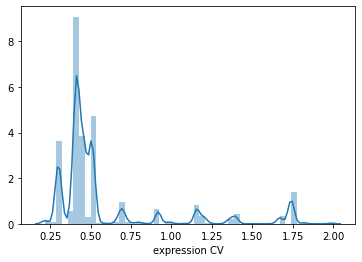

In [24]:
#plot all promoter distribution of TF CV values
all_prom_distribution(Czechowski_genetypes, 'expression_CV', 'expression CV', 'Czechowski_expressionCV')

## the CV values seem to mainly have low CVs so tend towards constitutive as in Czechowski et al 2005

('constitutive', 'variable')
('constitutive', 'control')
('variable', 'control')
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

constitutive v.s. variable: Custom statistical test, P_val:6.429e-01
variable v.s. control: Custom statistical test, P_val:6.353e-01
constitutive v.s. control: Custom statistical test, P_val:1.000e+00


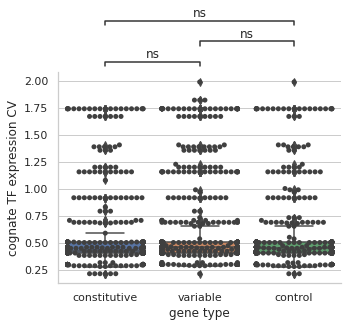

In [53]:
#plot the CV for each promoter gene_type - 400bp promoter individual TF CVs regardless of chromatin state
make_plot(Czechowski_genetypes,'gene_type', 'expression_CV','gene type', 'cognate TF expression CV', 'Czechowski_CV', 'box')

('constitutive', 'variable')
('constitutive', 'control')
('variable', 'control')
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

constitutive v.s. variable: Custom statistical test, P_val:1.701e-02
variable v.s. control: Custom statistical test, P_val:5.464e-02
constitutive v.s. control: Custom statistical test, P_val:1.000e+00


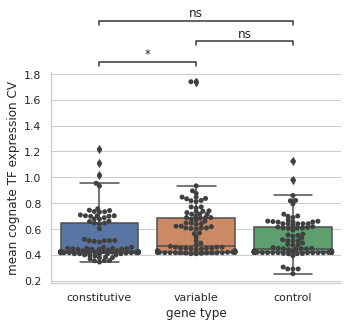

In [54]:
#plot the mean CV for each promoter gene_type - 400bp promoter mean TF expression
make_plot(Czechowski_means_sd_genetype,'gene_type', 'mean_cv','gene type', 'mean cognate TF expression CV', 'Czechowski_CV_mean', 'box')

('constitutive', 'variable')
('constitutive', 'control')
('variable', 'control')
p-value annotation legend:
ns: 5.00e-02 < p <= 1.00e+00
*: 1.00e-02 < p <= 5.00e-02
**: 1.00e-03 < p <= 1.00e-02
***: 1.00e-04 < p <= 1.00e-03
****: p <= 1.00e-04

constitutive v.s. variable: Custom statistical test, P_val:4.183e-01
variable v.s. control: Custom statistical test, P_val:7.983e-01
constitutive v.s. control: Custom statistical test, P_val:1.000e+00


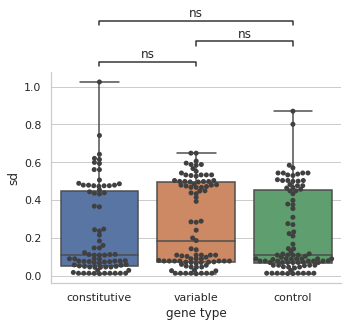

In [55]:
#plot the standard deviation of the CVs of the TFs binding each promoter split into gene_type
make_plot(Czechowski_means_sd_genetype,'gene_type', 'sd','gene type', 'sd', 'Czechowski_CV_sd', 'box')

## variable genes seem to have more variation in CV values of TFs that bind them. This makes sense since variable genes seem to have more diverse TFs binding them

In [28]:
# #now plot CV distribution for constitutive genes vs variable genes
#this took too long so commenting out for now
# make_plot(Czechowski_genetypes,'gene_type', 'expression_CV','gene type', 'expression CV', 'Czechowski_CV', 'box')

In [29]:
def test_normality(df,dependent_variable, between):
    """test normality of data categories"""
    #find gene_type categories
    pd.Categorical(df[between])
    names = df[between].unique()
    #Test normality
    #returns test statistic, p-value
    for name in names:
        print('{}: {}'.format(name, stats.shapiro(df[dependent_variable][df[between] == name])))

In [30]:
def describe_stats(df,dependent_variable, between):
    """return descriptve statistics"""
    return df.groupby([between])[dependent_variable].describe()

In [31]:
def variance(df, dependent_variable, between):
    """test variance of data categories"""
    #find gene_type categories
    pd.Categorical(df[between])
    names = df[between].unique()
    #test variance    
    return stats.levene(df[dependent_variable][df[between] == names[0]], 
               df[dependent_variable][df[between] == names[1]], 
               df[dependent_variable][df[between] == names[2]])

In [32]:
def kruskal_test(df,dependent_variable,between):
    """Do Kruskal-Wallis analysis"""
    #Kruskal-Wallis one way analysis of variance
    return kruskal(data=df, dv=dependent_variable, between=between)
    

In [33]:
def dunn_posthoc_test(df,dependent_variable, between):
    """dunn_posthoc tests with bonferroni multiple correction"""
    return sp.posthoc_dunn(df, val_col=dependent_variable, group_col=between, p_adjust='bonferroni')

In [34]:
Czechowski_genetypes

,promoter_AGI,gene_type,chr,start,stop,name_rep,score,strand,p-value,q-value,...,TF_family,TF_AGI,rank,probe_id,expression_mean,expression_SD,expression_CV,proportion_of_values_present_in_mas5,presence_in_araport11,constitutive_in_araport11
0,AT4G34270,constitutive,4,16406492.0,16406522.0,BBRBPC_tnt.BPC5_col_a,-48.5769,-,7.390000000000001e-05,0.0386,...,BBRBPC,AT4G38910,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,AT4G34270,constitutive,4,16406500.0,16406521.0,ND_tnt.FRS9_col_a,5.68254,+,2.53e-05,0.0203,...,ND,AT4G38170,4890.0,253029_at,69.694512,32.136091,0.461099,83.0,1.0,0.0
2,AT4G34270,constitutive,4,16406500.0,16406521.0,BBRBPC_tnt.BPC6_col_a,-2.58904,+,7.53e-05,0.0478,...,BBRBPC,AT5G42520,1524.0,249199_at,493.182683,149.269860,0.302666,98.0,1.0,0.0
3,AT4G33380,constitutive,4,16071439.0,16071458.0,MYBrelated_tnt.TBP3_colamp_a,17.7059,-,4.03e-07,0.0332,...,MYBRELATED,AT5G67580,206.0,247012_at,61.548600,13.354799,0.216980,100.0,1.0,0.0
4,AT4G33380,constitutive,4,16071443.0,16071458.0,MYBrelated_tnt.AT1G72740_col_a,17.5147,+,9.27e-07,0.0428,...,MYBRELATED,AT1G72740,1270.0,259924_at,258.939881,75.242398,0.290579,100.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2708,AT5G59820,control,5,24102802.0,24102826.0,BBRBPC_tnt.BPC1_col_a,-0.0625,-,4.74e-05,0.0253,...,BBRBPC,AT2G01930,5762.0,263305_at,181.275661,92.322959,0.509296,100.0,1.0,0.0
2709,AT5G59820,control,5,24102807.0,24102826.0,C2H2_tnt.TF3A_col_a,10.1278,+,2.9e-05,0.0403,...,C2H2,AT1G72050,3917.0,256344_at,432.292941,176.708645,0.408771,98.0,1.0,0.0
2710,AT5G59820,control,5,24102807.0,24102828.0,C2C2dof_tnt.OBP3_col_a,13.1094,+,1.53e-05,0.0374,...,C2C2DOF,AT3G55370,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2711,AT5G59820,control,5,24102997.0,24103016.0,ABI3VP1_tnt.VRN1_colamp_a,8.424660000000001,-,7.269999999999999e-05,0.0346,...,ABI3VP1,AT3G18990,4219.0,256944_at,336.280254,142.874959,0.424869,98.0,1.0,0.0


In [35]:
#rename df for easier analysis
df = Czechowski_means_sd_genetype
between_variable = 'gene_type'
dependent_variable = 'mean_cv'

In [36]:
test_normality(df,dependent_variable,between_variable)

constitutive: ShapiroResult(statistic=0.7572180032730103, pvalue=4.998492592056536e-11)
variable: ShapiroResult(statistic=0.6905438899993896, pvalue=6.349594786590751e-13)
control: ShapiroResult(statistic=0.8587117195129395, pvalue=3.216391064597701e-08)


## not normal

In [37]:
variance(df, dependent_variable,between_variable)

LeveneResult(statistic=2.450169887211551, pvalue=0.08810742748894217)

### fail to reject null hypothesis that variances are equal

In [38]:
#descriptive stats
describe_stats(df, dependent_variable,between_variable)

,count,mean,std,min,25%,50%,75%,max
gene_type,,,,,,,,
constitutive,92.0,0.520539,0.174459,0.344357,0.416223,0.431182,0.646198,1.215566
control,98.0,0.514402,0.147323,0.253779,0.419366,0.447247,0.614288,1.124533
variable,96.0,0.583216,0.228302,0.408771,0.421878,0.471833,0.688792,1.739770


In [39]:
kruskal_test(df, dependent_variable,between_variable)

,Source,ddof1,H,p-unc
Kruskal,gene_type,2,8.943272,0.011429


In [40]:
#significant difference in CV values between constitutive and variable or control 400bp promoters

In [41]:
dunn_posthoc_test(df, dependent_variable,between_variable)

,constitutive,control,variable
constitutive,-1.000000,1.000000,0.017012
control,1.000000,-1.000000,0.054637
variable,0.017012,0.054637,-1.000000


### constitutive have significantly lower mean cognate TF CV than variable genes 

In [42]:
## test to see if difference in standard_deviation between CV values of TFs binding each promoter for each promoter gene type

In [43]:
#rename df for easier analysis
df = Czechowski_means_sd_genetype
between_variable = 'gene_type'
dependent_variable = 'sd'

In [44]:
test_normality(df,dependent_variable,between_variable)

constitutive: ShapiroResult(statistic=nan, pvalue=1.0)
variable: ShapiroResult(statistic=nan, pvalue=1.0)
control: ShapiroResult(statistic=nan, pvalue=1.0)


In [45]:
#descriptive stats
describe_stats(df, dependent_variable,between_variable)

,count,mean,std,min,25%,50%,75%,max
gene_type,,,,,,,,
constitutive,79.0,0.226227,0.230611,0.009657,0.049757,0.108105,0.448376,1.024733
control,90.0,0.228161,0.215554,0.010417,0.068889,0.108105,0.454577,0.870077
variable,89.0,0.273032,0.221216,0.009657,0.072367,0.185091,0.495563,0.647788


In [46]:
kruskal_test(df, dependent_variable,between_variable)

,Source,ddof1,H,p-unc
Kruskal,gene_type,2,2.932945,0.230738


In [112]:
## no significant difference in TFBS CV sd between the promoter types